In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/Image based Colorectal Cancer diagnosis/High.zip" "High.zip"
!cp "/content/drive/My Drive/Image based Colorectal Cancer diagnosis/Low.zip" "Low.zip"
!cp "/content/drive/My Drive/Image based Colorectal Cancer diagnosis/Normal.zip" "Normal.zip"

In [ ]:
!unzip -q High.zip
!unzip -q Low.zip
!unzip -q Normal.zip

In [ ]:
!mkdir CRC_data
%cp -av Normal1 CRC_data
%cp -av High1 CRC_data
%cp -av Low1 CRC_data

Streaming output truncated to the last 5000 lines.
'High1/Patient_035_09_High-Gradepatch_35.png' -> 'CRC_data/High1/Patient_035_09_High-Gradepatch_35.png'
'High1/Patient_035_09_High-Gradepatch_36.png' -> 'CRC_data/High1/Patient_035_09_High-Gradepatch_36.png'
'High1/Patient_035_09_High-Gradepatch_37.png' -> 'CRC_data/High1/Patient_035_09_High-Gradepatch_37.png'
'High1/Patient_035_09_High-Gradepatch_38.png' -> 'CRC_data/High1/Patient_035_09_High-Gradepatch_38.png'
'High1/Patient_035_09_High-Gradepatch_39.png' -> 'CRC_data/High1/Patient_035_09_High-Gradepatch_39.png'
'High1/Patient_035_09_High-Gradepatch_4.png' -> 'CRC_data/High1/Patient_035_09_High-Gradepatch_4.png'
'High1/Patient_035_09_High-Gradepatch_40.png' -> 'CRC_data/High1/Patient_035_09_High-Gradepatch_40.png'
'High1/Patient_035_09_High-Gradepatch_41.png' -> 'CRC_data/High1/Patient_035_09_High-Gradepatch_41.png'
'High1/Patient_035_09_High-Gradepatch_42.png' -> 'CRC_data/High1/Patient_035_09_High-Gradepatch_42.png'
'High1/Patient_

In [ ]:
!rm -rf Normal1
!rm -rf High1
!rm -rf Low1

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math

class SeparableConv(nn.Module):
    def __init__(self, input_channel, output_channel, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super().__init__()
        self.dwc = nn.Sequential(
            nn.Conv2d(input_channel, input_channel, kernel_size, stride, padding, dilation, groups=input_channel, bias=bias),
            nn.Conv2d(input_channel, output_channel, 1, 1, 0, 1, 1, bias=bias)
        )
    
    def forward(self, X):
        return self.dwc(X)

class Block(nn.Module):
    def __init__(self, input_channel, out_channel, reps, strides=1, relu=True, grow_first=True):
        super().__init__()
        if out_channel != input_channel or strides!=1:
            self.skipConnection = nn.Sequential(
                nn.Conv2d(input_channel, out_channel, 1, stride=strides, bias=False),
                nn.BatchNorm2d(out_channel)
            )
        else:
            self.skipConnection = None
        self.relu = nn.ReLU(inplace=True)
        rep = []

        filters = input_channel
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv(input_channel, out_channel, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_channel))
            filters = out_channel
        
        for _ in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv(filters, filters, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(filters))
        
        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv(input_channel, out_channel, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_channel))

        if not relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3, strides, 1))

        self.rep = nn.Sequential(*rep)

    def forward(self, input):
        X = self.rep(input)

        if self.skipConnection:
            skip = self.skipConnection(input)
        else:
            skip = input
        
        X += skip
        return X

class Xception(nn.Module):
    def __init__(self, input_channel, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.relu = nn.ReLU(inplace=True)

        self.initBlock = nn.Sequential(
            nn.Conv2d(input_channel, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size = 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.block1=Block(64,128,2,2,relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block5=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block6=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block7=Block(728,728,3,1,relu=True,grow_first=True)

        #self.block8=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block9=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block10=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block11=Block(728,728,3,1,relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,relu=True,grow_first=False)

        self.conv3 = SeparableConv(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)

        #do relu here
        self.conv4 = SeparableConv(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, self.n_classes)

        #weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        x = self.initBlock(x)
        x = self.block1(x)
        
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        #x = self.block5(x)
        #x = self.block6(x)
        #x = self.block7(x)
        #x = self.block8(x)
        #x = self.block9(x)
        #x = self.block10(x)
        #x = self.block11(x)
        x = self.block12(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer):
    # meter
    loss = AverageMeter()
    # switch to train mode
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (data, target) in enumerate(tk0):
        
        data, target = data.to(device), target.to(device)  
        
        output = model(data) 
        # compute the loss function
        loss_this = F.cross_entropy(output, target)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter 
        loss.update(loss_this.item(), target.shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg    


def validate(model, device, val_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in val_loader:
      
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            
            output = model(data)
       
        loss_this = F.cross_entropy(output, target) 
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(val_loader.dataset), acc.avg))
    return loss.avg,acc.avg
##define test function



In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('CRC_data/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
train_files, val_files, train_classes, val_classes = train_test_split(files, classes, train_size=0.7, test_size=0.3, stratify=classes)

['High' 'Low' 'Normal']


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 10 # We use a small batch size here for training

batch_size_val = 10

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets
train_dataset = Hist('CRC_data/', train_files, train_classes, 
                         transforms=image_transform)
val_dataset = Hist('CRC_data/', val_files, val_classes, 
                         transforms=image_transform)


#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                           batch_size=batch_size_val, 
                                           shuffle=True, num_workers=2)



Label: Normal


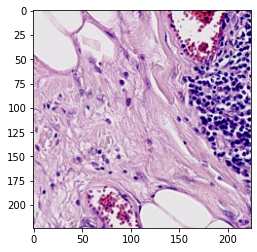

In [ ]:
# import library
import matplotlib.pyplot as plt
# Checking the data loader
_, (example_datas, labels) = next(enumerate(train_loader))
sample = example_datas[0]
# showing random image from dataloader
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
drive.flush_and_unmount()
!rm -rf /content/drive

In [ ]:
import os.path
from os import path
import torch.nn.functional as F
import torch.optim as optim

num_epoch = 100


for i in range(1):
  print('Experiment: ', i+1)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = Xception(input_channel=3, n_classes=3).to(device)
  learning_rate = 0.0009
  weight_decay = 0.001
  for param in model.parameters():
    param.requires_grad = True
  parameters = filter(lambda p: p.requires_grad, model.parameters())
  optimizer = optim.SGD(parameters, lr=learning_rate, momentum=0.99)

  acc=0
  for epoch in range(1, num_epoch + 1):
    print(epoch)
    tl=train(model, device, train_loader, optimizer)
    stl,acct=validate(model, device, val_loader)
    if acc<acct:
      if path.exists("Xception9SGD.pth"):
        os.remove("Xception9SGD.pth")
      torch.save(model.state_dict(), 'Xception9SGD.pth')
      acc=acct

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = Xception(input_channel=3, n_classes=3).to(device)
  model.load_state_dict(torch.load('Xception9SGD.pth', map_location=device))
  model=model.to(device)
  
 
print(acc)

Experiment:  1
1


<ipython-input-8-a57d00c2443e>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tk0 = tqdm(train_loader, total=int(len(train_loader)))


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 1.4605

Test: Average loss: 1.0496, Accuracy: 2819/4656 (60.55%)

2


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.9242

Test: Average loss: 0.6483, Accuracy: 3583/4656 (76.95%)

3


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.7263

Test: Average loss: 0.6082, Accuracy: 3618/4656 (77.71%)

4


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.6421

Test: Average loss: 0.5882, Accuracy: 3697/4656 (79.40%)

5


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.5646

Test: Average loss: 0.4283, Accuracy: 3863/4656 (82.97%)

6


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.5039

Test: Average loss: 0.4874, Accuracy: 3728/4656 (80.07%)

7


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.4988

Test: Average loss: 0.4268, Accuracy: 3779/4656 (81.16%)

8


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.4739

Test: Average loss: 0.4098, Accuracy: 3982/4656 (85.52%)

9


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.4402

Test: Average loss: 0.3862, Accuracy: 4000/4656 (85.91%)

10


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.4194

Test: Average loss: 0.4165, Accuracy: 3907/4656 (83.91%)

11


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.4151

Test: Average loss: 0.5603, Accuracy: 3567/4656 (76.61%)

12


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.3878

Test: Average loss: 0.4239, Accuracy: 3873/4656 (83.18%)

13


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.3663

Test: Average loss: 0.3238, Accuracy: 4117/4656 (88.42%)

14


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.3616

Test: Average loss: 0.3500, Accuracy: 4023/4656 (86.40%)

15


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.3461

Test: Average loss: 0.2946, Accuracy: 4141/4656 (88.94%)

16


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.3493

Test: Average loss: 0.2884, Accuracy: 4183/4656 (89.84%)

17


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.3325

Test: Average loss: 0.2698, Accuracy: 4194/4656 (90.08%)

18


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.3147

Test: Average loss: 0.2865, Accuracy: 4141/4656 (88.94%)

19


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.3037

Test: Average loss: 0.2399, Accuracy: 4270/4656 (91.71%)

20


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.2953

Test: Average loss: 0.2875, Accuracy: 4178/4656 (89.73%)

21


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.2835

Test: Average loss: 0.2648, Accuracy: 4227/4656 (90.79%)

22


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.2806

Test: Average loss: 0.2405, Accuracy: 4247/4656 (91.22%)

23


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.2797

Test: Average loss: 0.2252, Accuracy: 4268/4656 (91.67%)

24


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.2645

Test: Average loss: 0.2528, Accuracy: 4248/4656 (91.24%)

25


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.2563

Test: Average loss: 0.2269, Accuracy: 4276/4656 (91.84%)

26


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.2565

Test: Average loss: 0.2492, Accuracy: 4245/4656 (91.17%)

27


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.2477

Test: Average loss: 0.2221, Accuracy: 4291/4656 (92.16%)

28


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.2360

Test: Average loss: 0.2078, Accuracy: 4317/4656 (92.72%)

29


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.2231

Test: Average loss: 0.2846, Accuracy: 4206/4656 (90.34%)

30


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.2276

Test: Average loss: 0.2418, Accuracy: 4251/4656 (91.30%)

31


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.2193

Test: Average loss: 0.2196, Accuracy: 4287/4656 (92.07%)

32


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.2180

Test: Average loss: 0.1991, Accuracy: 4319/4656 (92.76%)

33


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.2174

Test: Average loss: 0.2060, Accuracy: 4330/4656 (93.00%)

34


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1988

Test: Average loss: 0.2103, Accuracy: 4303/4656 (92.42%)

35


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1898

Test: Average loss: 0.1863, Accuracy: 4337/4656 (93.15%)

36


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1900

Test: Average loss: 0.2195, Accuracy: 4299/4656 (92.33%)

37


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1729

Test: Average loss: 0.1889, Accuracy: 4358/4656 (93.60%)

38


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1710

Test: Average loss: 0.1871, Accuracy: 4353/4656 (93.49%)

39


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1714

Test: Average loss: 0.2505, Accuracy: 4249/4656 (91.26%)

40


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1858

Test: Average loss: 0.2333, Accuracy: 4285/4656 (92.03%)

41


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1677

Test: Average loss: 0.2499, Accuracy: 4228/4656 (90.81%)

42


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1567

Test: Average loss: 0.1816, Accuracy: 4354/4656 (93.51%)

43


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1564

Test: Average loss: 0.2226, Accuracy: 4304/4656 (92.44%)

44


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1426

Test: Average loss: 0.2081, Accuracy: 4315/4656 (92.68%)

45


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1563

Test: Average loss: 0.1565, Accuracy: 4387/4656 (94.22%)

46


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1418

Test: Average loss: 0.2714, Accuracy: 4299/4656 (92.33%)

47


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1412

Test: Average loss: 0.2257, Accuracy: 4314/4656 (92.65%)

48


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1395

Test: Average loss: 0.2308, Accuracy: 4292/4656 (92.18%)

49


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1343

Test: Average loss: 0.2436, Accuracy: 4310/4656 (92.57%)

50


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1203

Test: Average loss: 0.2283, Accuracy: 4299/4656 (92.33%)

51


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1339

Test: Average loss: 0.1828, Accuracy: 4359/4656 (93.62%)

52


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1127

Test: Average loss: 0.1969, Accuracy: 4350/4656 (93.43%)

53


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1142

Test: Average loss: 0.2100, Accuracy: 4324/4656 (92.87%)

54


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1053

Test: Average loss: 0.1935, Accuracy: 4367/4656 (93.79%)

55


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0991

Test: Average loss: 0.2944, Accuracy: 4270/4656 (91.71%)

56


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1004

Test: Average loss: 0.2028, Accuracy: 4357/4656 (93.58%)

57


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1048

Test: Average loss: 0.2261, Accuracy: 4326/4656 (92.91%)

58


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0915

Test: Average loss: 0.2019, Accuracy: 4356/4656 (93.56%)

59


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0858

Test: Average loss: 0.2417, Accuracy: 4356/4656 (93.56%)

60


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0975

Test: Average loss: 0.1925, Accuracy: 4377/4656 (94.01%)

61


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0860

Test: Average loss: 0.2210, Accuracy: 4339/4656 (93.19%)

62


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1015

Test: Average loss: 0.2000, Accuracy: 4351/4656 (93.45%)

63


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0755

Test: Average loss: 0.2012, Accuracy: 4359/4656 (93.62%)

64


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0968

Test: Average loss: 0.1915, Accuracy: 4362/4656 (93.69%)

65


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0845

Test: Average loss: 0.2328, Accuracy: 4301/4656 (92.38%)

66


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0713

Test: Average loss: 0.1981, Accuracy: 4357/4656 (93.58%)

67


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0703

Test: Average loss: 0.1880, Accuracy: 4390/4656 (94.29%)

68


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0684

Test: Average loss: 0.2150, Accuracy: 4342/4656 (93.26%)

69


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0718

Test: Average loss: 0.2128, Accuracy: 4387/4656 (94.22%)

70


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0667

Test: Average loss: 0.2069, Accuracy: 4360/4656 (93.64%)

71


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0748

Test: Average loss: 0.1979, Accuracy: 4371/4656 (93.88%)

72


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0774

Test: Average loss: 0.1942, Accuracy: 4391/4656 (94.31%)

73


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0641

Test: Average loss: 0.2263, Accuracy: 4350/4656 (93.43%)

74


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0743

Test: Average loss: 0.2049, Accuracy: 4315/4656 (92.68%)

75


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0562

Test: Average loss: 0.2133, Accuracy: 4343/4656 (93.28%)

76


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0533

Test: Average loss: 0.2374, Accuracy: 4340/4656 (93.21%)

77


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0673

Test: Average loss: 0.2018, Accuracy: 4367/4656 (93.79%)

78


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0698

Test: Average loss: 0.2518, Accuracy: 4292/4656 (92.18%)

79


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0553

Test: Average loss: 0.1818, Accuracy: 4389/4656 (94.27%)

80


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0447

Test: Average loss: 0.2092, Accuracy: 4384/4656 (94.16%)

81


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0578

Test: Average loss: 0.1975, Accuracy: 4363/4656 (93.71%)

82


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0526

Test: Average loss: 0.2222, Accuracy: 4358/4656 (93.60%)

83


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0560

Test: Average loss: 0.2048, Accuracy: 4353/4656 (93.49%)

84


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0561

Test: Average loss: 0.2337, Accuracy: 4365/4656 (93.75%)

85


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0467

Test: Average loss: 0.2489, Accuracy: 4311/4656 (92.59%)

86


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0482

Test: Average loss: 0.2329, Accuracy: 4366/4656 (93.77%)

87


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0503

Test: Average loss: 0.2137, Accuracy: 4388/4656 (94.24%)

88


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0409

Test: Average loss: 0.2159, Accuracy: 4376/4656 (93.99%)

89


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0430

Test: Average loss: 0.2232, Accuracy: 4385/4656 (94.18%)

90


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0473

Test: Average loss: 0.2823, Accuracy: 4290/4656 (92.14%)

91


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0682

Test: Average loss: 0.2262, Accuracy: 4375/4656 (93.96%)

92


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0493

Test: Average loss: 0.2415, Accuracy: 4353/4656 (93.49%)

93


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0462

Test: Average loss: 0.1908, Accuracy: 4393/4656 (94.35%)

94


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0385

Test: Average loss: 0.2187, Accuracy: 4387/4656 (94.22%)

95


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0371

Test: Average loss: 0.2103, Accuracy: 4363/4656 (93.71%)

96


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0340

Test: Average loss: 0.2458, Accuracy: 4370/4656 (93.86%)

97


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0373

Test: Average loss: 0.2061, Accuracy: 4399/4656 (94.48%)

98


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0384

Test: Average loss: 0.2323, Accuracy: 4332/4656 (93.04%)

99


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0343

Test: Average loss: 0.2348, Accuracy: 4355/4656 (93.54%)

100


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0371

Test: Average loss: 0.2440, Accuracy: 4366/4656 (93.77%)

94.48024054982818
